
## Cifar
1. [Erstellen Sie ein Jupyter notebook, welches den cifar10 Datensatz mit Hilfe von Keras klassifiziert.](#section_ID) 
2. [Zeichnen Sie sowohl die Verlustkurve als auch die Genauigkeit](#section_ID2)
3. [Zeigen Sie darüber hinaus verschiedene Möglichkeiten die Genauigkeit zu verbessern und damit dem Bias-Variance Tradeoff entgegen zu wirken](#section_ID3)en. 

## Klassifizierung des cifar10 Datensatzes <a id="section_ID"></a>

In [1]:
# Notwendige Bibliotheken Importieren
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD, RMSprop
from keras.regularizers import l1, l2
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Cifar10-Daten in train/test-Images und -Labels laden 
# Dauert ein paar Minuten (bei mir hat es ca. 10-15 Minuten gedauert)
(org_train_images, org_train_labels), (org_test_images, org_test_labels) = cifar10.load_data()

In [3]:
# Normalisierung der Pixelwerte, die zwischen 0 und 255 liegen (Cifar10 Datensatz) auf einen Wert zwischen 0 und 1
train_images = org_train_images.astype('float32') / 255
test_images = org_test_images.astype('float32') / 255

print(f"Anzahl Trainingsbilder: {len(train_images)}")
print(f"Die Bildgröße entspricht: {len(train_images[0])} x {len(train_images[0][0])}")

Anzahl Trainingsbilder: 50000
Die Bildgröße entspricht: 32 x 32


In [4]:
# One-Hot-Encoding - Umwandlung der Labelvektoren der Cifar10 Labels in eine Binärliste der Länge der Anzahl von Klassen
# mit entsprechenden 1 und 0 Werten (je nachdem ob ein Label vertreten ist oder nicht)
train_labels = to_categorical(org_train_labels)
test_labels = to_categorical(org_test_labels)

print(f"Anzahl Klassen, die vorgesagt werden können: {len(train_labels[0])}")
print(f"Erste Klasse: {org_train_labels[0]}")
train_labels[0]

Anzahl Klassen, die vorgesagt werden können: 10
Erste Klasse: [6]


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [5]:
# Ein einfaches sequentielles CNN-Modell:
# * Die Eingabeschicht erwartet Bilder der Größe 32x32 Pixel mit einer kernel_size von 3 (3x3 Matrize).
# * Es folgen zwei Conv2D-Layer
# * Nach jedem Conv2D-Layer reduziert ein MaxPooling2D-Layer die räumlichen Dimensionen des Bildes um den Faktor 2.
# * Der Flatten-Layer konvertiert die 2D-Ausgabe der vorherigen Schicht in einen 1D-Vektor.
# * Der Dense Layer mit 512 Neuronen und ReLu-Aktivierung dient als Hidden Layer.
# * Der abschließende Dense-Layer mit 10 Neuronen gibt die Wahrscheinlichkeiten für die 10 Klassen aus und verwendet die Softmax-Aktivierungsfunktion.
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(10, activation='softmax')
])

In [6]:
# Das Modell kompilieren und trainieren (Insgesamt 10 Epochen)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_images, 
                    train_labels, 
                    epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 9s 4ms/step - loss: 1.3572 - accuracy: 0.5124 - val_loss: 1.1005 - val_accuracy: 0.6183
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.9915 - accuracy: 0.6524 - val_loss: 0.9451 - val_accuracy: 0.6680
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8095 - accuracy: 0.7179 - val_loss: 0.9314 - val_accuracy: 0.6818
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.6675 - accuracy: 0.7667 - val_loss: 0.8351 - val_accuracy: 0.7186
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.5284 - accuracy: 0.8161 - val_loss: 0.9010 - val_accuracy: 0.7048
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.3991 - accuracy: 0.8611 - val_loss: 0.9281 - val_accuracy: 0.7154
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2869 - accuracy: 0.8995 - val_loss: 1.0316 - val_accuracy:

In [7]:
def print_accuracy(model_to_eval):
    # Ausgabe der Accuracy des Modells angewendet an die Testdaten
    loss, accuracy = model_to_eval.evaluate(test_images, test_labels)

    # Ausgabe der Genauigkeit
    print(f"Accuracy: {accuracy * 100:.2f}%")

In [8]:
print_accuracy(model)

313/313 [==============================] - 1s 2ms/step - loss: 1.5729 - accuracy: 0.6895
Accuracy: 68.95%


Die Genauigkeit liegt hier bei lediglich knappen **70 %**.

## Verlustkurve und Genauigkeit <a id="section_ID2"></a> 

In [9]:
def plot_loss_acc(hist):
    plt.figure(figsize=(12,4))

    # Verlustkurve zeichnen für die 10 Epochen
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['loss'], label='Trainingsverlust')
    plt.plot(hist.history['val_loss'], label='Validierungsverlust')
    plt.legend()
    plt.title('Verlustkurve')
    
    # Genauigkeit aufzeigen für die 10 Epochen
    plt.subplot(1, 2, 2)
    plt.plot(hist.history['accuracy'], label='Trainingsgenauigkeit')
    plt.plot(hist.history['val_accuracy'], label='Validierungsgenauigkeit')
    plt.legend()
    plt.title('Genauigkeit')

    plt.tight_layout()
    plt.show()

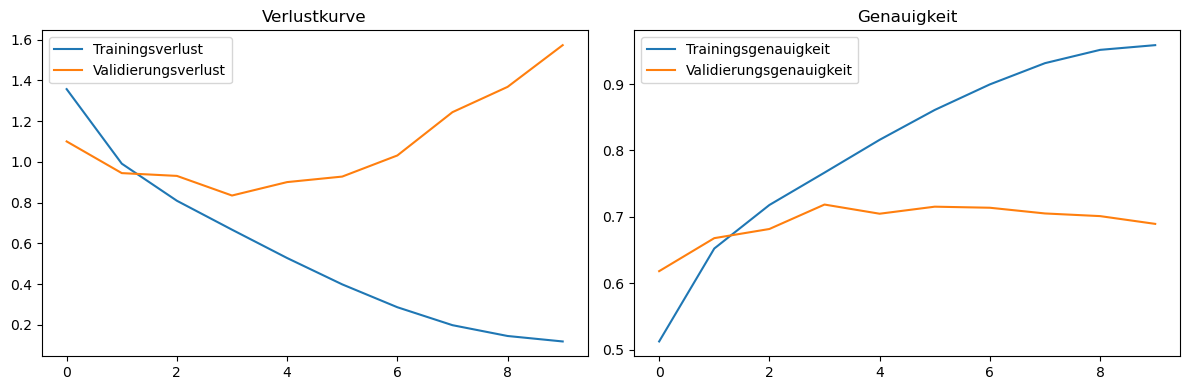

In [10]:
plot_loss_acc(history)

### Erkläuterungen
**Verlustkurve**: Während der Trainingsverlust stetig abnimmt, zeigt der Validierungsverlust nach den ersten Epochen eine Zunahme, was auf ein Überanpassen (Overfitting) des Modells an die Trainingsdaten hindeutet.

**Genauigurve**: Die Trainingsgenauigkeit steigt kontinuierlich an und nähert sich 1, während die Validierungsgenauigkeit nach einem anfänglichen Anstieg stagniert, was erneut an eine Überanpassung des Modells bestätigt.

### Bias-Variance Tradeoff
**Bias** Der stetige Abfall des Trainingsverlusts und die Annäherung der Trainingsgenauigkeit an 1 zeigen, dass das Modell eine geringe Verzerrung (Bias) aufweist und die Trainingsdaten gut anpasst.

**Varianz** 
Die Zunahme des Validierungsverlusts und die Stagnation der Validierungsgenauigkeit deuten jedoch auf eine hohe Varianz hin. Das Modell ist zu komplex und "überangepasst" an die Trainingsdaten, wodurch seine Fähigkeit, auf neue Daten zu generalisieren, beeinträchtigt wird

**Ziel** 
Das Ziel ist es, ein Gleichgewicht zwischen Bias und Varianz zu finden, um sicherzustellen, dass das Modell weder underfittet noch overfittet, sondern gut auf neue, unbekannte Daten generalisiert.igt.igt.

## Möglichkeiten zur Verbesserung der Genauigkeit - Bias-Variance Tradeoff entgegenwirken <a id="section_ID3"></a>
- Data Augmentation 
- Weitere Schichten im Modell
- Regularisierungsmethoden
- Early Stopping
- Hyperparameter-Tuningusw.

### Early Stopping
Beim zu schnellen Overfitten kann das Modell durch Early Stopping davon gehindert werden noch weiter trainiert zu werden um einer Überanpassung entgegen zu wirken.

In [11]:
from keras.callbacks import EarlyStopping

# Initialisierung des EarlyStopping-Callback. Es soll hier der Validation Loss gemonitort werden, dabei werden max. 3 Epochen weiter trainiert, 
# wenn keine Verbesserung eintritt wird dann gestoppt. Wenn das Training vorzeitig beendet wird, so sollen die besten Gewichte wiederhergestellt werden.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

model_es = model

# Modelltraining mit dem Callback
history_early_stopping = model_es.fit(
    train_images, train_labels,
    epochs=10,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0975 - accuracy: 0.9666 - val_loss: 1.6041 - val_accuracy: 0.6880
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0925 - accuracy: 0.9687 - val_loss: 1.7190 - val_accuracy: 0.7065
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0779 - accuracy: 0.9732 - val_loss: 1.8921 - val_accuracy: 0.7043
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0779 - accuracy: 0.9741 - val_loss: 1.9045 - val_accuracy: 0.7067


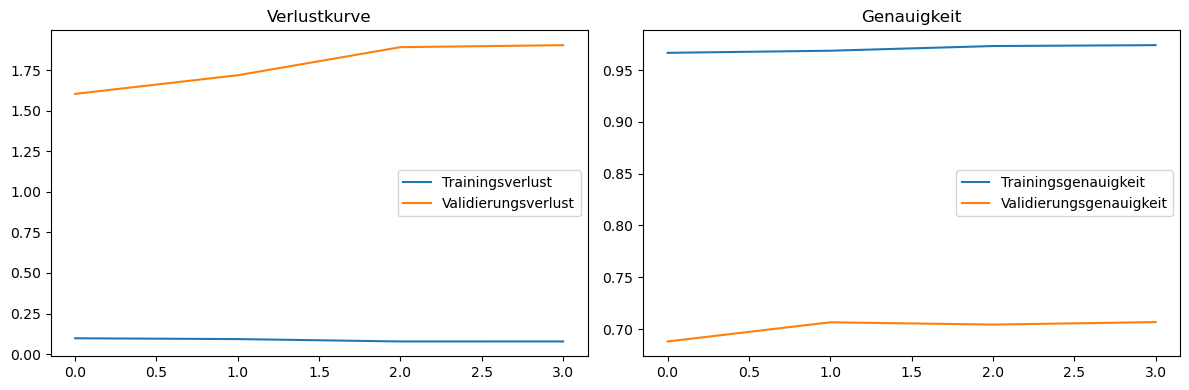

313/313 [==============================] - 1s 2ms/step - loss: 1.6041 - accuracy: 0.6880
Accuracy: 68.80%


In [12]:
plot_loss_acc(history_early_stopping)
print_accuracy(model_es)

Eine Genuaigkeit von rund **70 %** ohne besondere Anpassungen.

### Regularisierungsmethoden - Dropout

Das Training zeigt nun eine deutlich stabilere und konsistentere Performance. Während der Trainingsverlust und die Trainingsgenauigkeit sehr niedrig bzw. hoch sind und sich während des Trainings kaum ändern, bleibt der Validierungsverlust stabil und die Validierungsgenauigkeit ist nicht mehr so weit vom Training entfernt, was auf eine Reduzierung des Overfittings hinweist.

Dies hat jedoch nicht zur Steigerung der Genauigkeit des Modells beigetragen.

In [13]:
# Regularisierungsmethoden
# l2_coefficient = 0.01

# Sequentielles CNN Modell mit drei Dropout-Layern.
model_do = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(2, 2),
    Dropout(0.2), # Dropout 1
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2), # Dropout 2
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout 3
    Dense(10, activation='softmax')
])

# Kompilierung des Modells
model_do.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping auf 5 erhöht, da zu schnell abgebrochen wurde.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Modelltraining, und weil vergleichsweise viele Neuronen "ausgeknockt" werden durch den Dropout, erhöhe ich die Anzahl der Epochen.
history_drop_out = model_do.fit(
    train_images, train_labels,
    epochs=30,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)
# Anmerkung: ich habe das Modell häufiger neu trainiert... die Anzahl der Epochen habe ich Schrittweise von 10 auf 30 gesteigert, da sich 
# selbst nach 15 Epochen noch höhere Genauigkeiten ergeben haben... Nach 15 Epochen ist die Genauigkeit bei 74,24% gelegen.

Epoch 1/30
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5041 - accuracy: 0.4563 - val_loss: 1.1378 - val_accuracy: 0.6026
Epoch 2/30
1563/1563 [==============================] - 6s 4ms/step - loss: 1.1695 - accuracy: 0.5876 - val_loss: 1.0197 - val_accuracy: 0.6534
Epoch 3/30
1563/1563 [==============================] - 6s 4ms/step - loss: 1.0331 - accuracy: 0.6342 - val_loss: 0.9498 - val_accuracy: 0.6744
Epoch 4/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9570 - accuracy: 0.6671 - val_loss: 0.9214 - val_accuracy: 0.6858
Epoch 5/30
1563/1563 [==============================] - 7s 4ms/step - loss: 0.9046 - accuracy: 0.6825 - val_loss: 0.8989 - val_accuracy: 0.6875
Epoch 6/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8566 - accuracy: 0.7007 - val_loss: 0.8557 - val_accuracy: 0.7058
Epoch 7/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.8140 - accuracy: 0.7165 - val_loss: 0.7973 - val_accuracy:

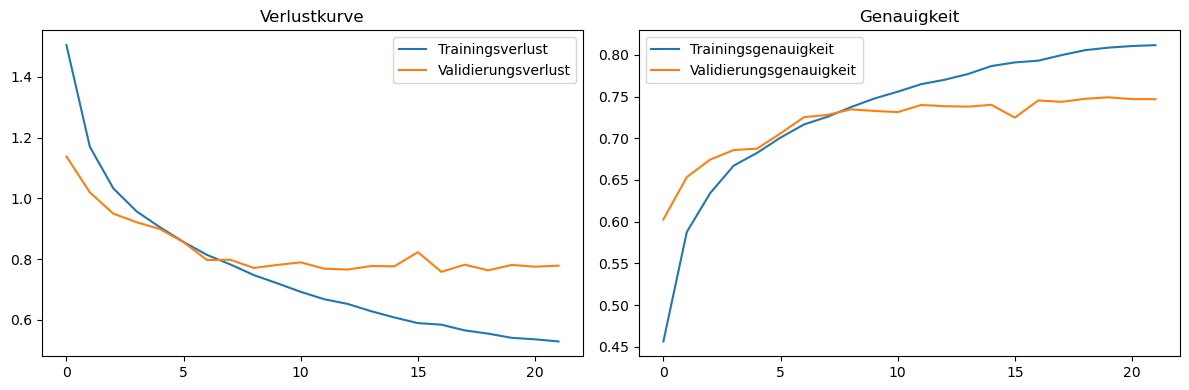

313/313 [==============================] - 1s 2ms/step - loss: 0.7584 - accuracy: 0.7453
Accuracy: 74.53%


In [14]:
# Plotten der History 
plot_loss_acc(history_drop_out)
# Ausgabe der Accuracy
print_accuracy(model_do)

### Hyperparameter-Tuning
Beim Training des obigen Modells wurde bereits an Hyperparametern rumprobiert:
- Dropout von 0.2 bis 0.5 in den unterschiedlichen Schichten probiert. 
 - bestes Ergebnis bei DropOut 1 = 0.33, DropOut 2 = 0.33, DropOut 3 = 0.50
- Early Stopping von 1 bis 5
 - Kaum Auswirkung auf das Modell mit den drei Drop-Out-Schichten, da hier in kleineren Schritten gelernt wird.
- Verschiedene Optimierer ausprobiert (Adam, RMSprop, SGD)
 - bestes Ergebnis bei Adam > trainiert am schnellsten und mit einer hohen Genauigkeit.
- Verwendung von L1 und L2-Regularisierung im Dense Layer
 - bestes Ergebnis bei

**Ergebnisse:**
- Dropout 1,2,3 = 0.33 & Adam & ReLu & SoftMax > 30 Epochen und patience=3 > Training nach 15 Epochen beendet mit einer Accuracy von **73,56** %
- **Dropout 1,2 = 0.20 & Dropout 3 = 0.50** & Adam & ReLu % SoftMax > Training nach 19 Epochen beendet mit einer Accuracy von **74,53** %
- Dropout 1,2 = 0.20 & Dropout 3 = 0.50 & **SGD** & ReLu % SoftMax > Training nach 30 Epochen mit einer Accuracy von **72,29** % > geht zu langsam :-/ nicht Ressourcensparend.
- Dropout 1,2 = 0.20 & Dropout 3 = 0.50 & **RMSprop** & ReLu & SoftMax > Training nach 9 Epochen mit einer Accuracy von **67,27** % beendet > zu schnell beendet worden. Die Verlustkurve und die Genauigkeit sind etwas sprunghaft. Learning Rate sollte angepasst werden.
- Dropout 1,2 = 0.20 & Dropout 3 = 0.50 & **RMSprop mit LR von 0.0001** & ReLu & SoftMax > Training nach 30 Epochen mit einer Accuracy von **72,38** %
- Dropout 1,2 = 0.20 & Dropout 3 = 0.50 & Adam & ReLu % SoftMax & **L1 Regularisierung coeff 0.001** > Nach der 4. Epoche noch unter 40 % Accuracy, das ist nix. L1 neigt dazu die Gewichte gegen Null zu setzen, was hier fehl am platz ist.
- - Dropout 1,2 = 0.20 & Dropout 3 = 0.50 & Adam & ReLu % SoftMax & **L2 Regularisierung coeff 0.001** > Nach der 4. Epoche noch unter 40 % Accuracy, das bringt das Modell auch nicht weiter. Die Gewichte scheinen gut zu passen, sodass eine Regularisieung nicht notwendig erscheint und das Training eher extrem verlangsamt.

**Fazit:**
- Adam und stärkere Dropouts sind schon einmal ein guter Anfang. Nächster Versuch zu Optimieren: Mehr Layer.

### Modell um weitere Schichten erweitern

In [15]:
# Sequentielles CNN Modell mit drei Dropout-Layern.
model_ml = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2), # Dropout 1
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.2), # Dropout 2
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5), # Dropout 3
    Dense(10, activation='softmax')
])

# Kompilierung des Modells
model_ml.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Modelltraining, und weil vergleichsweise viele Neuronen "ausgeknockt" werden durch den Dropout, erhöhe ich die Anzahl der Epochen.
history_more_layer = model_ml.fit(
    train_images, train_labels,
    epochs=30,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

Epoch 1/30
1563/1563 [==============================] - 11s 7ms/step - loss: 1.5666 - accuracy: 0.4260 - val_loss: 1.3044 - val_accuracy: 0.5271
Epoch 2/30
1563/1563 [==============================] - 10s 6ms/step - loss: 1.1485 - accuracy: 0.5925 - val_loss: 1.0165 - val_accuracy: 0.6381
Epoch 3/30
1563/1563 [==============================] - 10s 6ms/step - loss: 0.9844 - accuracy: 0.6539 - val_loss: 0.8833 - val_accuracy: 0.6937
Epoch 4/30
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8904 - accuracy: 0.6895 - val_loss: 0.8192 - val_accuracy: 0.7193
Epoch 5/30
1563/1563 [==============================] - 10s 6ms/step - loss: 0.8246 - accuracy: 0.7093 - val_loss: 0.7683 - val_accuracy: 0.7377
Epoch 6/30
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7721 - accuracy: 0.7302 - val_loss: 0.7419 - val_accuracy: 0.7463
Epoch 7/30
1563/1563 [==============================] - 10s 6ms/step - loss: 0.7358 - accuracy: 0.7415 - val_loss: 0.7225 - val_ac

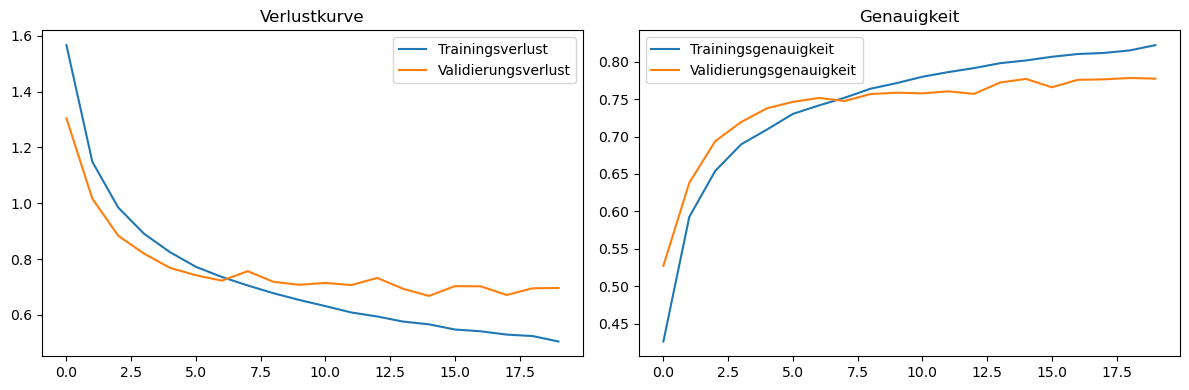

313/313 [==============================] - 1s 3ms/step - loss: 0.6678 - accuracy: 0.7770
Accuracy: 77.70%


In [16]:
# Plotten der History 
plot_loss_acc(history_more_layer)
# Ausgabe der Accuracy
print_accuracy(model_ml)

Nach 20 Epochen einen Genauigkeitswert von rund **77 %** erreicht. Das ist immerhin **3 % besser**.
Bevor Data Augmentation versucht wird, könnte noch eine BatchNormalisation helfen.

### BatchNormalisation
Batch-Normalisierung bewirkt eine normalisierung der interne Verteilung der Aktivierungen während des Trainings. Sie wurde eingeführt, um das Training von tiefen Netzwerken zu beschleunigen und die Notwendigkeit, Initialisierungen sorgfältig auszuwählen, zu verringern.we

In [17]:
# CNN mit BatchNormalization
model_bn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2), # Dropout 1
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.2), # Dropout 2
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5), # Dropout 3
    Dense(10, activation='softmax')
])

# Kompilierung des Modells
model_bn.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Modelltraining, und weil vergleichsweise viele Neuronen "ausgeknockt" werden durch den Dropout, erhöhe ich die Anzahl der Epochen.
history_batch_norm = model_bn.fit(
    train_images, train_labels,
    epochs=50,
    validation_data=(test_images, test_labels),
    callbacks=[early_stopping]
)

Epoch 1/50
1563/1563 [==============================] - 14s 8ms/step - loss: 1.5486 - accuracy: 0.4823 - val_loss: 1.2881 - val_accuracy: 0.5457
Epoch 2/50
1563/1563 [==============================] - 13s 8ms/step - loss: 1.0428 - accuracy: 0.6353 - val_loss: 1.2237 - val_accuracy: 0.5827
Epoch 3/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.9177 - accuracy: 0.6802 - val_loss: 1.1989 - val_accuracy: 0.6250
Epoch 4/50
1563/1563 [==============================] - 12s 8ms/step - loss: 0.8286 - accuracy: 0.7113 - val_loss: 0.8081 - val_accuracy: 0.7162
Epoch 5/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7720 - accuracy: 0.7296 - val_loss: 0.6844 - val_accuracy: 0.7605
Epoch 6/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.7124 - accuracy: 0.7518 - val_loss: 0.7028 - val_accuracy: 0.7543
Epoch 7/50
1563/1563 [==============================] - 13s 8ms/step - loss: 0.6666 - accuracy: 0.7671 - val_loss: 0.7664 - val_ac

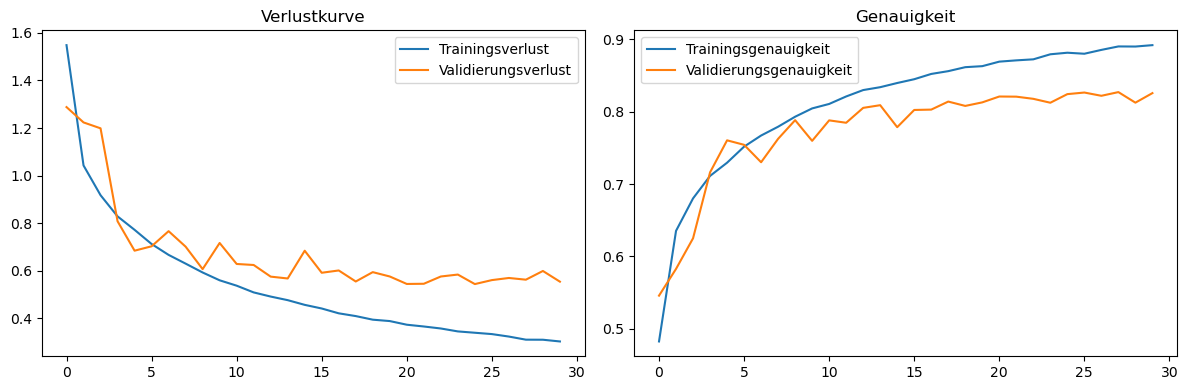

313/313 [==============================] - 1s 3ms/step - loss: 0.5439 - accuracy: 0.8244
Accuracy: 82.44%


In [18]:
# Plotten der History 
plot_loss_acc(history_batch_norm)
# Ausgabe der Accuracy
print_accuracy(model_bn)

Nach nur 30 Epochen einen Genauigkeitswert von **82,44 %** erreicht. Das ist immerhin etwas mehr als **4 % besser**.
Letzter Optimierungsversuch: Data Augmentation

### Data Augmentation

In [22]:
# Initialisierung der Data Augmentation
# rotation_range gibt an wie das Bild gedreht werden soll. Bei 5 wird es zufällig im Bereich von -5 und +5 Grad gedreht.
# width_shift_range gibt die horizontale Verschiebung an
# height_shift_range gibt entsprechend die vertikale Verschiebung an
# zoom_range gibt den Zoomfaktor entsprechend an. Bei 10 wird zwischen -10% und +10% Zoom zufällig entschieden.
# horizontal_flip gibt ab ob ein Bild per Zufall horizontal umgeklappt werden soll
# fill_mode gibt an wie die durch die Manipulation des Bildes entstandenen Lücken im Bild gefüllt werden sollen.

datagen = ImageDataGenerator(
    rotation_range=15,     
    zoom_range=0.1,      
    horizontal_flip=True,    
    fill_mode='nearest'      
)

# Generator an die Daten fitten
datagen.fit(train_images)

Epoch 1/200
1563/1563 [==============================] - 23s 15ms/step - loss: 0.3919 - accuracy: 0.8659 - val_loss: 0.4163 - val_accuracy: 0.8588
Epoch 2/200
1563/1563 [==============================] - 23s 15ms/step - loss: 0.3870 - accuracy: 0.8652 - val_loss: 0.3996 - val_accuracy: 0.8685
Epoch 3/200
1563/1563 [==============================] - 24s 15ms/step - loss: 0.3855 - accuracy: 0.8665 - val_loss: 0.4053 - val_accuracy: 0.8625
Epoch 4/200
1563/1563 [==============================] - 23s 15ms/step - loss: 0.3814 - accuracy: 0.8670 - val_loss: 0.4025 - val_accuracy: 0.8685
Epoch 5/200
1563/1563 [==============================] - 24s 15ms/step - loss: 0.3813 - accuracy: 0.8683 - val_loss: 0.3777 - val_accuracy: 0.8711
Epoch 6/200
1563/1563 [==============================] - 23s 15ms/step - loss: 0.3828 - accuracy: 0.8684 - val_loss: 0.4164 - val_accuracy: 0.8588
Epoch 7/200
1563/1563 [==============================] - 23s 15ms/step - loss: 0.3788 - accuracy: 0.8704 - val_loss: 0

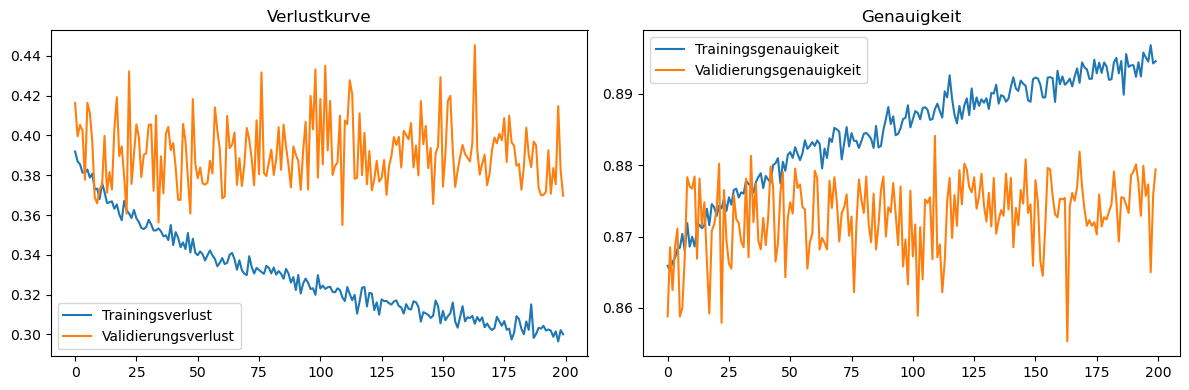

313/313 [==============================] - 1s 3ms/step - loss: 0.3697 - accuracy: 0.8794
Accuracy: 87.94%


In [23]:
# Anwendung der Data Augmentation auf das Modell, das bisher am besten abgeschnitten hat.
model_bn_da = model_bn
history_bn_da = model_bn_da.fit(
    datagen.flow(train_images, train_labels, batch_size=32),
    epochs=200,
    validation_data=(test_images, test_labels),
    workers=4
)
# Plotten der History 
plot_loss_acc(history_bn_da)
# Ausgabe der Accuracy
print_accuracy(model_bn_da)

Die Genauigkeit hat erneut um etwas über **6 %** auf knapp **88 %** zugenommen. Der Trainingsverlust und der Validationverlust haben sich langsam eingependelt.